# COVID-19 Machine Learning-Based Rapid Diagnosis From Common Laboratory Tests

Tharsis Souza, Ph.D. and Gustavo Sainatto, M.D.

## Abstract

*The sudden and rapid growth of COVID-19 cases is overwhelming health systems globally. Fast, accurate and early detection of SARS-CoV-2 is of vital importance to control the spread of the virus. However, traditional SARS-CoV-2 detection based on RT-PCR assays can be costly, long-drawn-out and widely unavailable making testing every case an impractical effort. In this work, we propose a machine learning-based approach for the rapid detection of COVID-19 cases using commonly available laboratory test data. We analyze a sample of 5644 patients of which 558 tested positive for SARS-CoV-2 from the Hospital Israelita Albert Einstein, at São Paulo, Brazil. The proposed model presents an overall high performance of 92% (AUC) considering a held-out test group of ⅓ of the original sample data. We observe that patients admitted with COVID-19 symptoms who tested negative for Rhinovirus Enterovirus, Influenza B and Inf.A.H1N1.2009 and presented low levels of Leukocytes and Platelets were more likely to test positive for SARS-CoV-2. We also present a parameterized model based on different scenarios which are given as a function of a target Sensitivity level or the total number of potential positive cases the hospital would have the capacity to prioritize. At a 25% capacity rate of patients deemed SARS-CoV-2 positive, the proposed model shows Sensitivity and Specificity of over 84% and 96%, respectively, hence proving to be a useful rapid prioritization tool.*

## Introduction

### Background

The World Health Organization (WHO) characterized COVID-19, caused by SARS-CoV-2, as a pandemic on March 11, while the exponential increase in the number of cases was risking to overwhelm health systems around the world with a demand for ICU beds far above the existing capacity, with regions of Italy being prominent examples.

Brazil recorded the first case of SARS-CoV-2 on February 26, and the virus transmission evolved from imported cases only to local and finally community transmission very rapidly, with the federal government declaring nationwide community transmission on March 20.

Until March 27 2020, the state of São Paulo had recorded 1,223 confirmed cases of COVID-19, with 68 related deaths, while the county of São Paulo, with a population of approximately 12 million people and where Hospital Israelita Albert Einstein is located, had 477 confirmed cases and 30 associated deaths, as of March 23. Both the state and the county of São Paulo decided to establish quarantine and social distancing measures, that will be enforced at least until early April, in an effort to slow the virus spread.

## Motivation and Objectives

This work has the objective to predict confirmed COVID-19 cases among suspected cases based on commonly collected laboratory exams.
We consider the following research question:

*Based on the results of laboratory tests commonly collected for a suspected COVID-19 case during a visit to the emergency room, would it be possible to predict the test result for SARS-Cov-2 (positive/negative)?*

One of the motivations for this work is the fact that in the context of an overwhelmed health system with the possible limitation to perform tests for the detection of SARS-CoV-2, testing every case would be impractical and considering that tests results takes from 48 hours to a whole week, they could be delayed even if only a target subpopulation would be tested.

## Contribution

This work suggests a simple model to quickly predict patients at the highest risk of having contracted SARS-CoV-2, enabling them to be prioritized and potentially allowing for isolation measures and associated medical procedures. Our contributions are three-fold:

1. A rapid- high-accuracy test for SARS-CoV-2: The proposed model is solely based on commonly available laboratory test data and it presents high performance with 92% AUC and Sensitivity levels greater than 85% with reasonable Specificity levels of over 85%

2. Interpretability: Variable importance and conditional dependencies with the outcome variable are easily extracted from the model and its interpretation can guide medical decision-making

3. Flexibility: Model construction is flexible to different policy scenarios depending on target Sensitivity levels, hospital capacity and disease prevalence


## Dataset

The dataset contains anonymized data from patients seen at the Hospital Israelita Albert Einstein, at São Paulo, Brazil, and who had samples collected to perform the SARS-CoV-2 RT-PCR and additional laboratory tests during a visit to the hospital.

All data were anonymized following the best international practices and recommendations. All clinical data were standardized to have a mean of zero and a unit standard deviation.

In [1]:
# load aux functions
source("../input/00funcsr/00-Funcs.R")

#load input dataset
library("readxl");
data <- as.data.frame(read_excel("../input/covid19/dataset.xlsx"), stringAsFactors=F)

The dataset contains 109 variables (predictors), a Patient ID and one target outcome variable, which indicates whether the patient tested positive/negative for SARS-Cov-2. There are 5644 samples available with 558 positive cases, which constitutes 10% of the dataset.

### Data Preparation

Firstly, we perform some basic data cleaning procedures:

1. Make variable names syntactically valid by removing special characters, spaces and symbols
2. Convert strings that represent missing data to **NA**, namely the following values: 'Não Realizado' and 'not_done'
3. Convert string categorical values to factors
4. Convert the variable **Urine...pH** to numeric, as it contains a mix of string and numeric values in the input data

In [2]:
# make variable names syntactically valid
names(data) <- make.names(names(data))
data$Patient.ID <- NULL

# Replace column values that should be empty for NA
data[data=='Não Realizado'] <- NA
data[data=='not_done'] <- NA
data[data=='<1000'] <- 500

data$Urine...Leukocytes <- as.integer(data$Urine...Leukocytes)
data$Urine...pH <- as.integer(data$Urine...pH)

# convert string values to factors
ind <- sapply(data, is.character)
data[ind] <- lapply(data[ind], factor)

data$Lipase.dosage <- as.factor(data$Lipase.dosage)

Our outcome variable is given by the name **SARS.Cov.2.exam.result**, it is a binary variable which indicates whether the patient tested positive or negative for the virus SARS-COV2. We convert this variable such that $SARS.Cov.2.exam.result = 1$, if the patient tested positive and $SARS.Cov.2.exam.result = 0$, otherwise.

In [3]:
outcome.var<-"SARS.Cov.2.exam.result"
data[, outcome.var] <- as.integer(data[, outcome.var]) - 1

As observed below, most of the variables have a very high percentage of missing values (NA's). The concern here is that these predictors may become zero-variance predictors when the data are split into cross-validation/bootstrap sub-samples in the predictive modeling we propose.

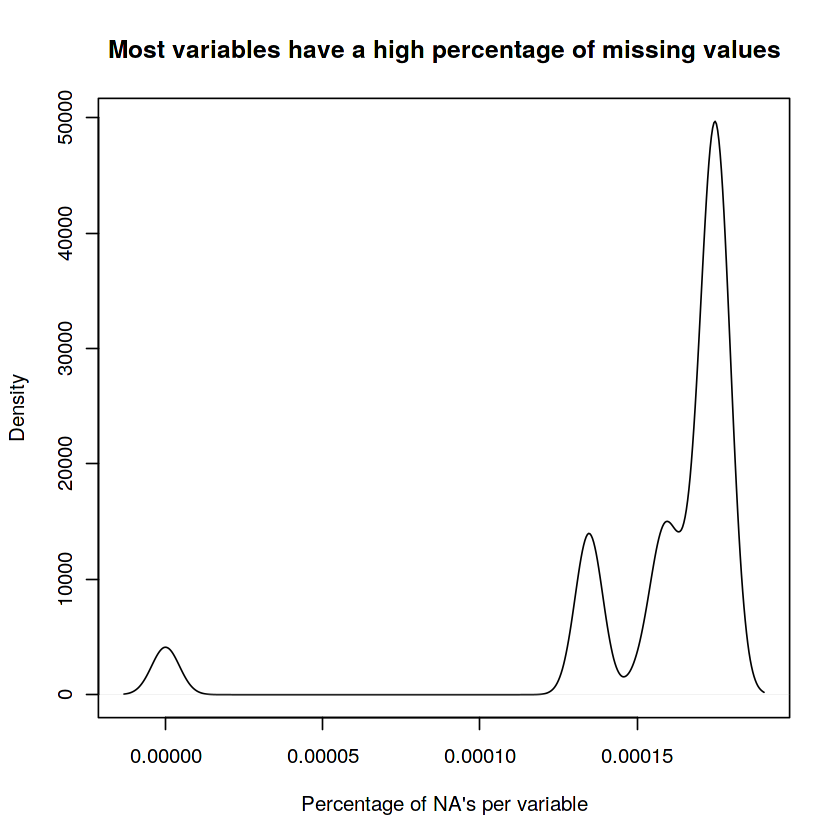

In [4]:
countNA<-function(x){sum(is.na(x))}
x<-apply(data, 2, countNA)/nrow(data)
plot(density(x/nrow(data)), main="Most variables have a high percentage of missing values", xlab="Percentage of NA's per variable")

Hence, we remove variables that have too many missing data points (>= 95%). We also remove samples that are too sparse in laboratory data, we choose to keep negative samples that have at least 10 variables with data points available. This is performed to avoid an overfit scenario where a few samples (sparse but positive) may have an undue influence on the predictive model.

In [5]:
data.saved<-data
data.size<-nrow(data)
not.na.pct <- 0.05
data <- delete.na(data, n = data.size * not.na.pct, is.row = FALSE)


data.pos <- data[data$SARS.Cov.2.exam.result==1,]
data.neg <-  data[data$SARS.Cov.2.exam.result==0,]

### delete poor samples
min.non.na.vars <- 10
data.neg <- delete.na(data.neg, n = min.non.na.vars)

data <- rbind(data.pos, data.neg)

The following variables were dropped:

In [6]:
print(setdiff(names(data.saved), names(data)))

 [1] "Serum.Glucose"                            
 [2] "Mycoplasma.pneumoniae"                    
 [3] "Alanine.transaminase"                     
 [4] "Aspartate.transaminase"                   
 [5] "Gamma.glutamyltransferase."               
 [6] "Total.Bilirubin"                          
 [7] "Direct.Bilirubin"                         
 [8] "Indirect.Bilirubin"                       
 [9] "Alkaline.phosphatase"                     
[10] "Ionized.calcium."                         
[11] "Magnesium"                                
[12] "pCO2..venous.blood.gas.analysis."         
[13] "Hb.saturation..venous.blood.gas.analysis."
[14] "Base.excess..venous.blood.gas.analysis."  
[15] "pO2..venous.blood.gas.analysis."          
[16] "Fio2..venous.blood.gas.analysis."         
[17] "Total.CO2..venous.blood.gas.analysis."    
[18] "pH..venous.blood.gas.analysis."           
[19] "HCO3..venous.blood.gas.analysis."         
[20] "Rods.."                                   
[21] "Segmented"    

The remaining variables are the following:

In [7]:
print(names(data))

 [1] "Patient.age.quantile"                                 
 [2] "SARS.Cov.2.exam.result"                               
 [3] "Patient.addmited.to.regular.ward..1.yes..0.no."       
 [4] "Patient.addmited.to.semi.intensive.unit..1.yes..0.no."
 [5] "Patient.addmited.to.intensive.care.unit..1.yes..0.no."
 [6] "Hematocrit"                                           
 [7] "Hemoglobin"                                           
 [8] "Platelets"                                            
 [9] "Mean.platelet.volume"                                 
[10] "Red.blood.Cells"                                      
[11] "Lymphocytes"                                          
[12] "Mean.corpuscular.hemoglobin.concentration..MCHC."     
[13] "Leukocytes"                                           
[14] "Basophils"                                            
[15] "Mean.corpuscular.hemoglobin..MCH."                    
[16] "Eosinophils"                                          
[17] "Mean.corpuscular.v

## Predictive Analysis

### Model Training

To predict the likelihood that a patient is infected with the SARS-Cov2 virus, we split the dataset randomly into training and testing tests in a train-to-test split ratio of 2/3. We decompose the dataset such that the outcome variable also follows the same split ratio between train and test sets.


In [8]:
library(caret)
set.seed(18101987)
SPLIT.RATIO <- 2/3
train.index <- createDataPartition(data$SARS.Cov.2.exam.result, p = SPLIT.RATIO, list = FALSE)
train <- data[train.index,]
test <- data[-train.index,]

Loading required package: lattice

Loading required package: ggplot2


Attaching package: ‘caret’


The following object is masked from ‘package:httr’:

    progress





We train a GBM model using the remaining dataset variables as predictors. We also define a bag fraction which defines the fraction of the training set observations randomly selected to propose the next tree in the expansion. This introduces randomnesses into the model fit and reduces overfitting.

In [9]:
train.features <- setdiff(names(train), c(outcome.var, "Patient.ID"))
myformula = as.formula(paste0(outcome.var," ~ ", paste0(train.features, collapse="+")))

BAG.FRACTION <- 0.8
library(gbm)
gbm.model = gbm(myformula, data = train,
                n.trees = 500 ,
                bag.fraction = BAG.FRACTION,
                verbose=FALSE)

Loaded gbm 2.1.5



Distribution not specified, assuming bernoulli ...


Warning message in gbm.fit(x = x, y = y, offset = offset, distribution = distribution, :
“variable 35: Parainfluenza.2 has no variation.”


### Model Interpretability

We evaluate model interpretability by looking at the relative importance of the variables as well as their conditional dependency probability relative to the outcome variable. Model explanations are important because they can be used to improve medical decision-making and guide policy-making initiatives.

The top 10 most important variables returned by the model are given below. The importance measures are normalized and they are based on the number of times a variable is selected for tree splitting, weighted by the improvement to the model as a result of each split, and averaged over all trees.

                                                                                          var
Rhinovirus.Enterovirus                                                 Rhinovirus.Enterovirus
Influenza.B                                                                       Influenza.B
Leukocytes                                                                         Leukocytes
Platelets                                                                           Platelets
Inf.A.H1N1.2009                                                               Inf.A.H1N1.2009
Eosinophils                                                                       Eosinophils
Patient.addmited.to.regular.ward..1.yes..0.no. Patient.addmited.to.regular.ward..1.yes..0.no.
Respiratory.Syncytial.Virus                                       Respiratory.Syncytial.Virus
Monocytes                                                                           Monocytes
Patient.age.quantile                                        

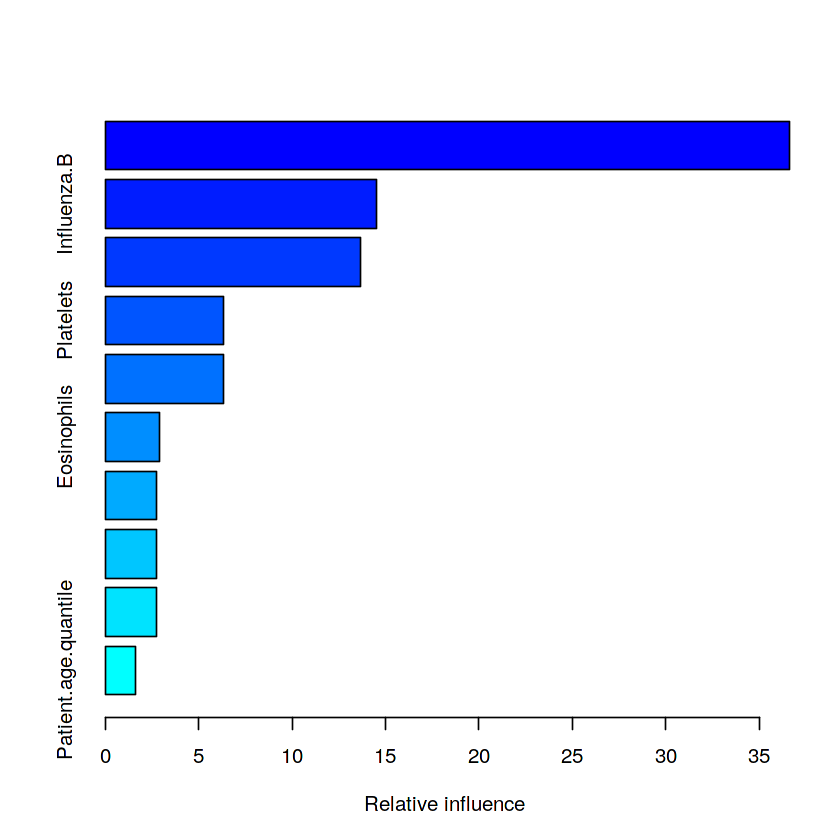

In [10]:
model.summary<-summary(gbm.model, cBars=10)
print(model.summary[1:10,])

We also analyze the conditional probability plots of the top 5 most important variables below, where the x-axis represents the predictor and the y-axis represents the likelihood of infection (numbers are normalized). We observe the following:

1. When Rhinovirus.Enterovirus, Influenza.B or Inf.A.H1N1.2009 are not detected, patients are more likely to test positive for SARS-COV2
2. Patients with low Leukocytes or Platelets are more likely to test positive for SARS-COV2

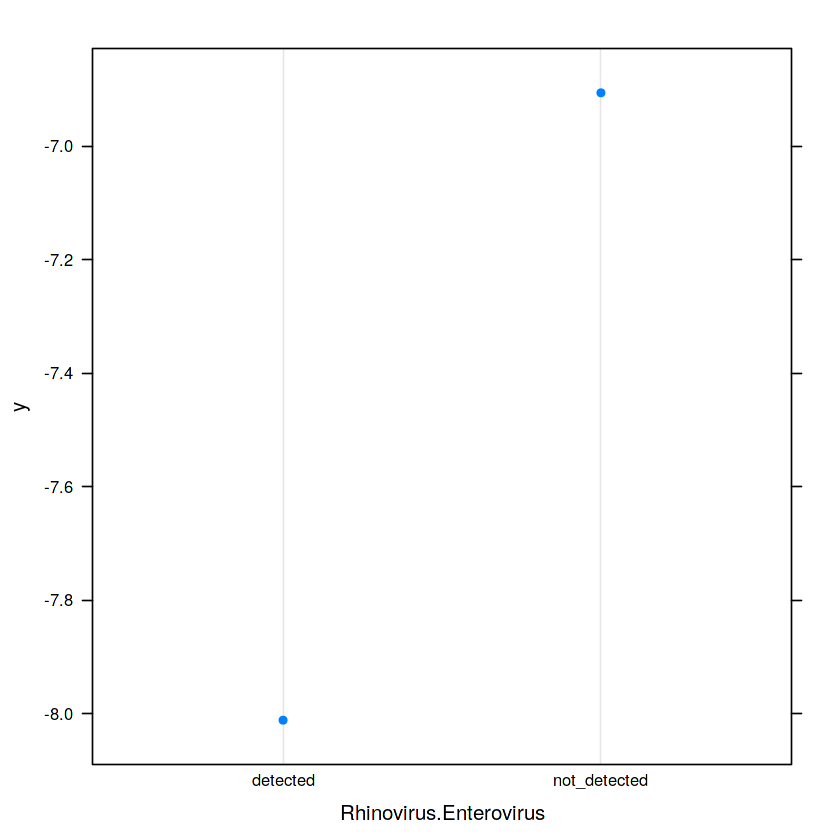

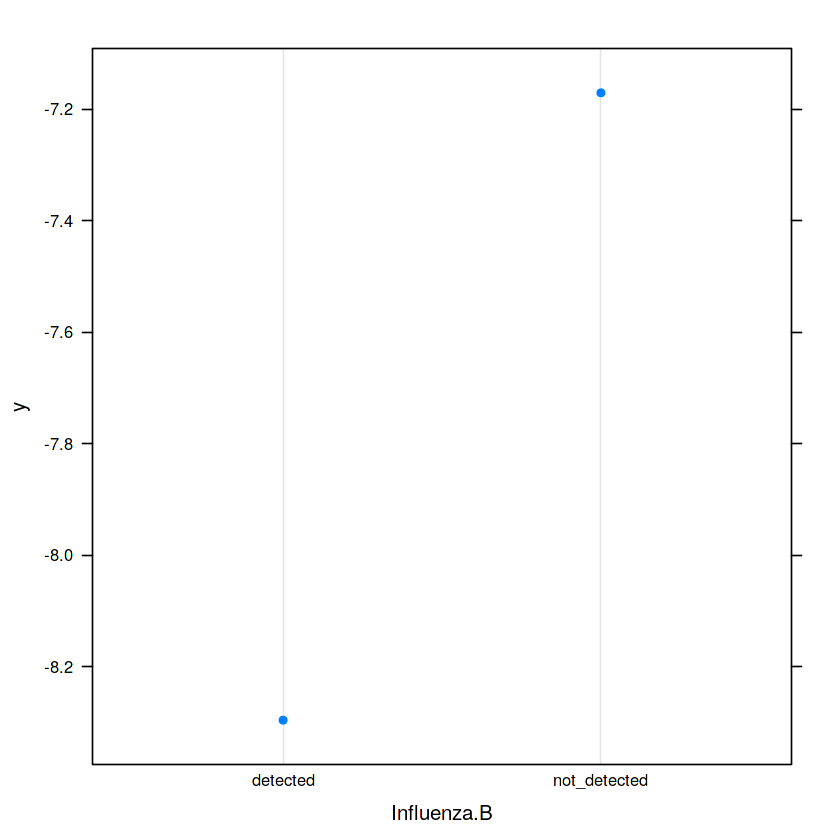

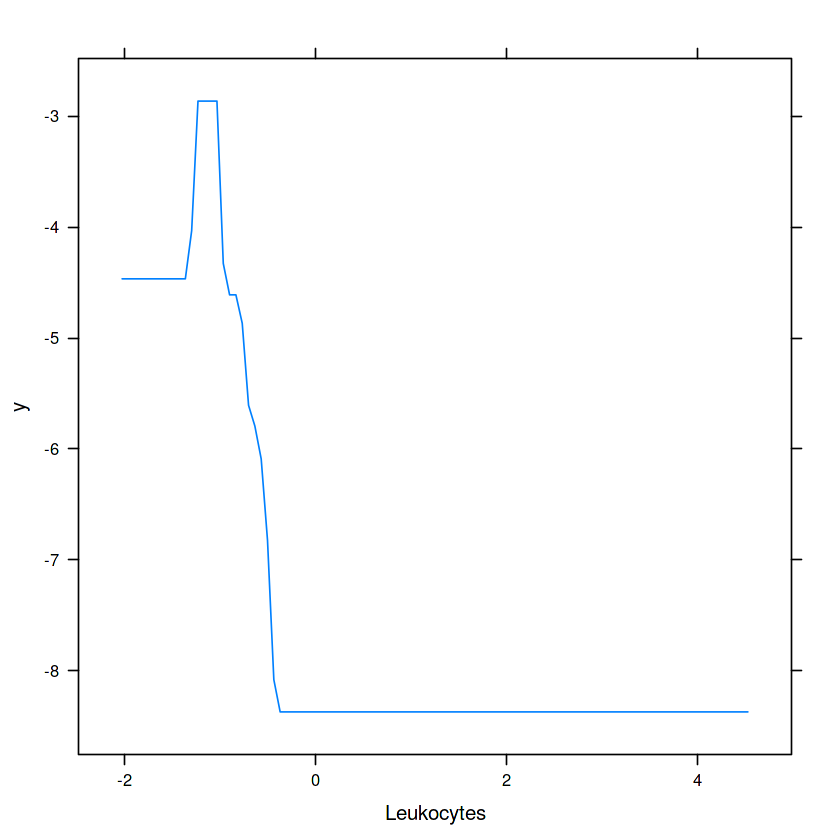

[[1]]

[[2]]

[[3]]

[[4]]

[[5]]


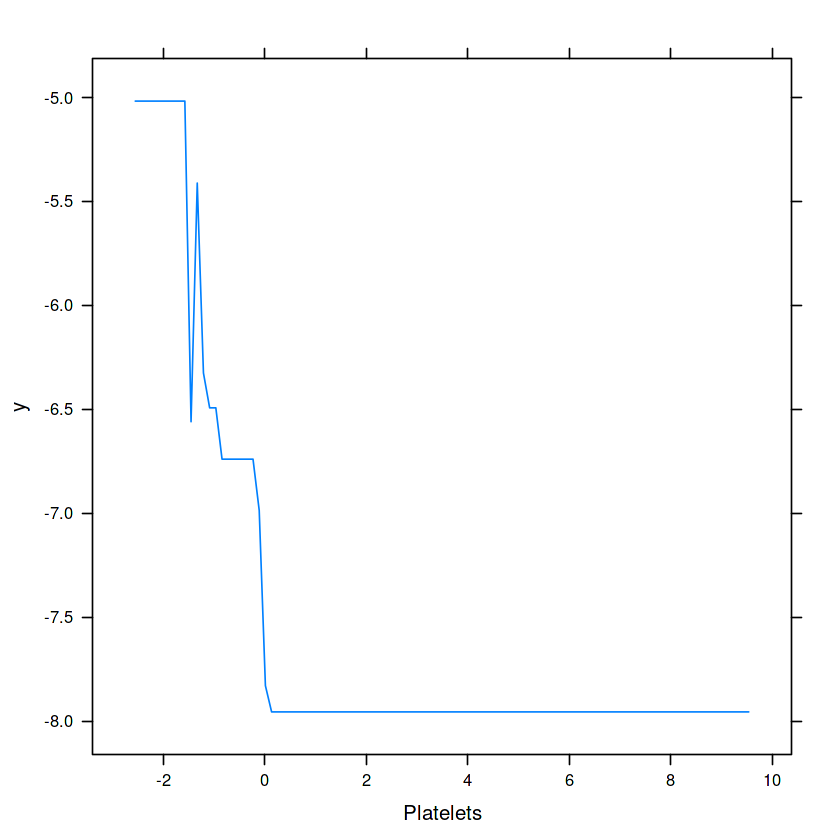

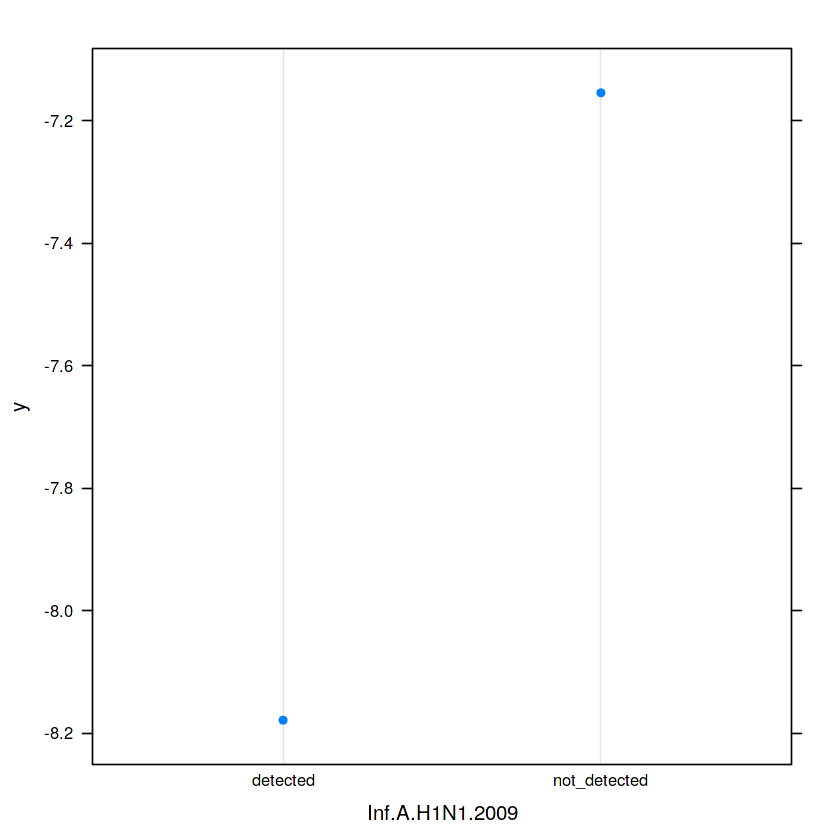

In [11]:
lapply(as.character(model.summary$var[1:5]), plot.gbm, x=gbm.model)

One variable that is widely discussed as a leading indicator of severe COVID-19 cases is age. Hence, we analyze the bivariate relationship between the variable *age_quantile* and the top 5 most important variables discussed previously. We observe that a patient's age quantile can increase the likelihood of SARS-COV2 infection when taken in conjunction with the other top 5 variables studied.

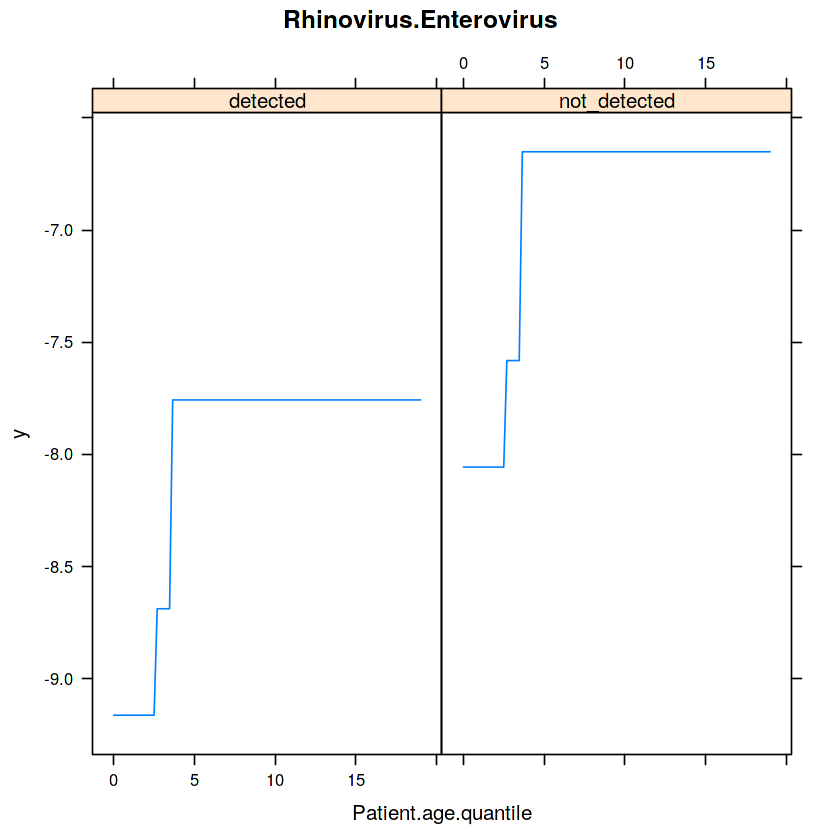

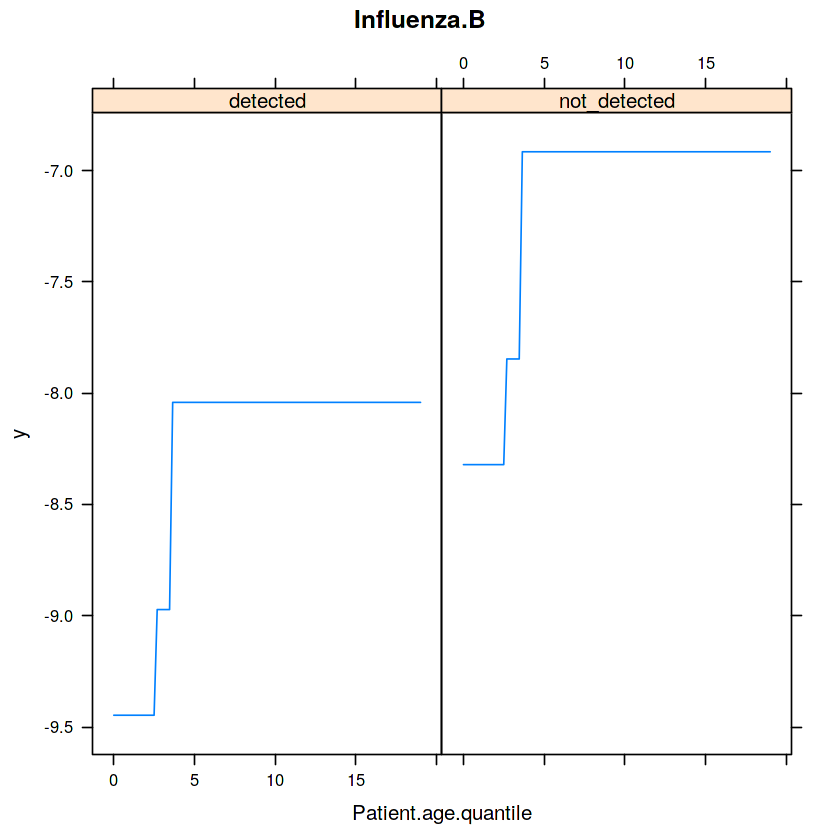

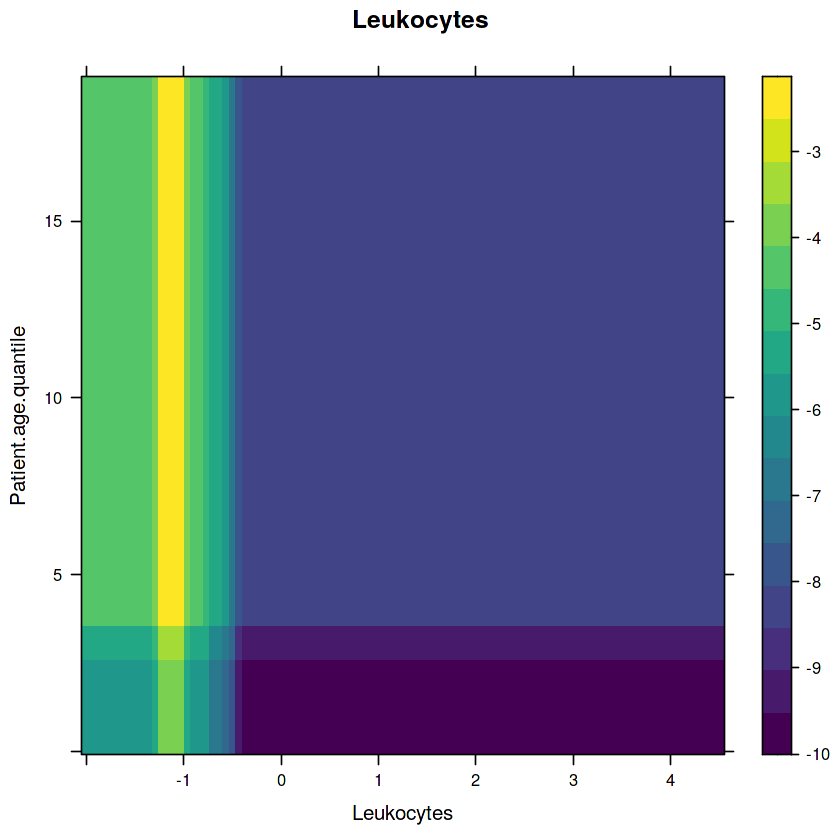

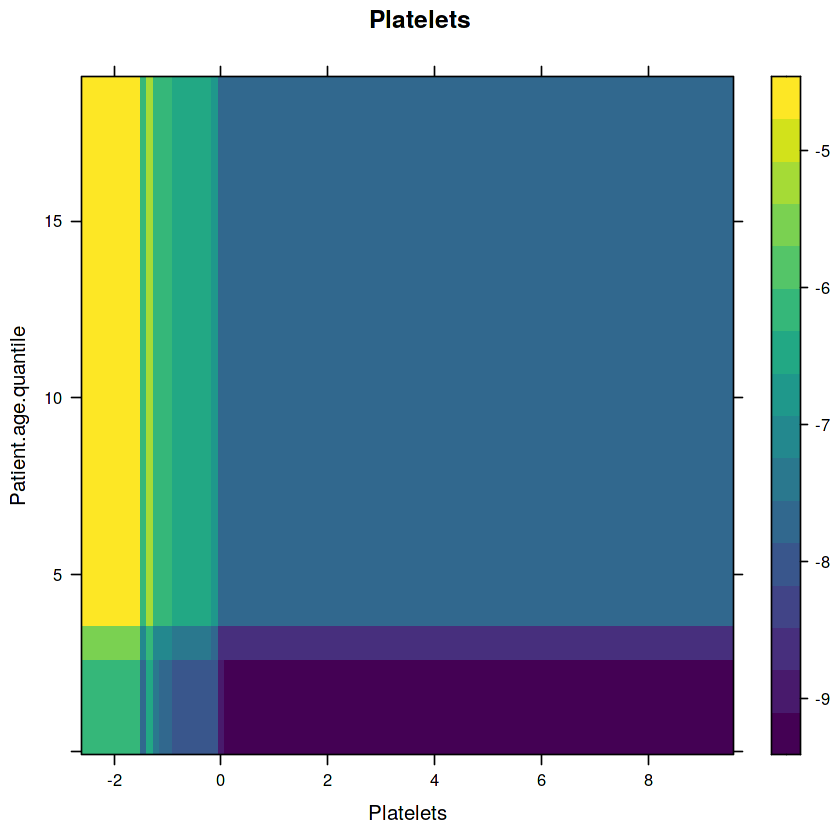

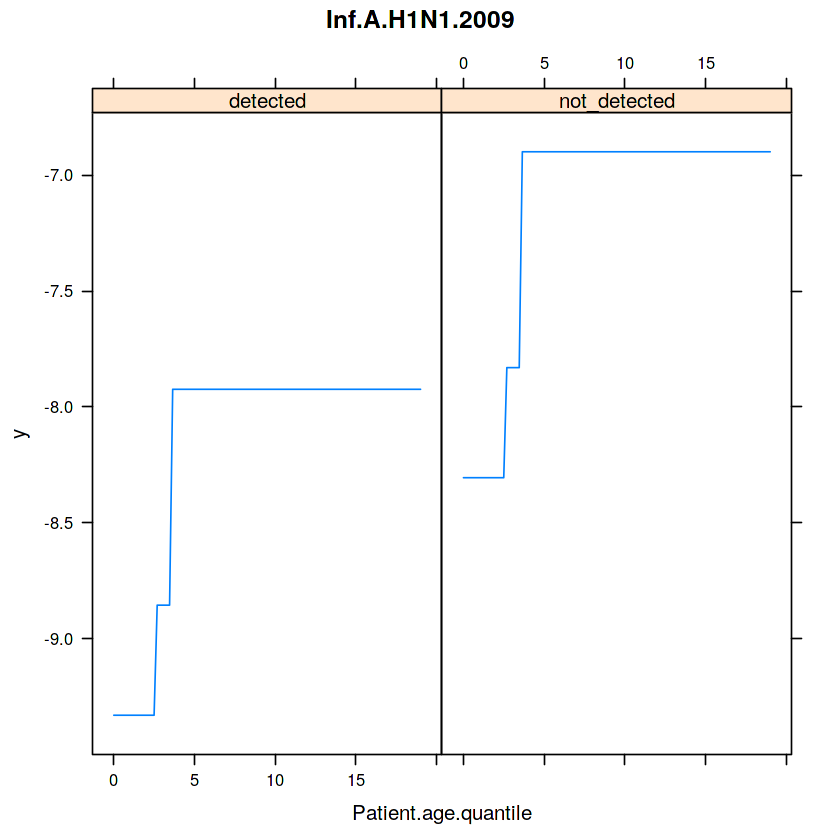

In [12]:
plot.gbm(gbm.model, i.var = c(as.character(model.summary$var[1]), 'Patient.age.quantile'),  main="Rhinovirus.Enterovirus")
plot.gbm(gbm.model, i.var = c(as.character(model.summary$var[2]), 'Patient.age.quantile'),  main="Influenza.B")
plot.gbm(gbm.model, i.var = c(as.character(model.summary$var[3]), 'Patient.age.quantile'),  main="Leukocytes")
plot.gbm(gbm.model, i.var = c(as.character(model.summary$var[4]), 'Patient.age.quantile'),  main="Platelets") 
plot.gbm(gbm.model, i.var = c(as.character(model.summary$var[5]), 'Patient.age.quantile'),  main="Inf.A.H1N1.2009") 

### Prediction

We apply the trained model to the test dataset of 668 patients. We observe that the model performs very well with an AUC of 92%. However, the determination of model's specificity and sensitivity relies on the definition of a likelihood threshold to determine patients that will be considered as likely positive COVID-19 cases among suspected cases.  

Type 'citation("pROC")' for a citation.


Attaching package: ‘pROC’


The following objects are masked from ‘package:stats’:

    cov, smooth, var


Setting levels: control = 0, case = 1

Setting direction: controls < cases



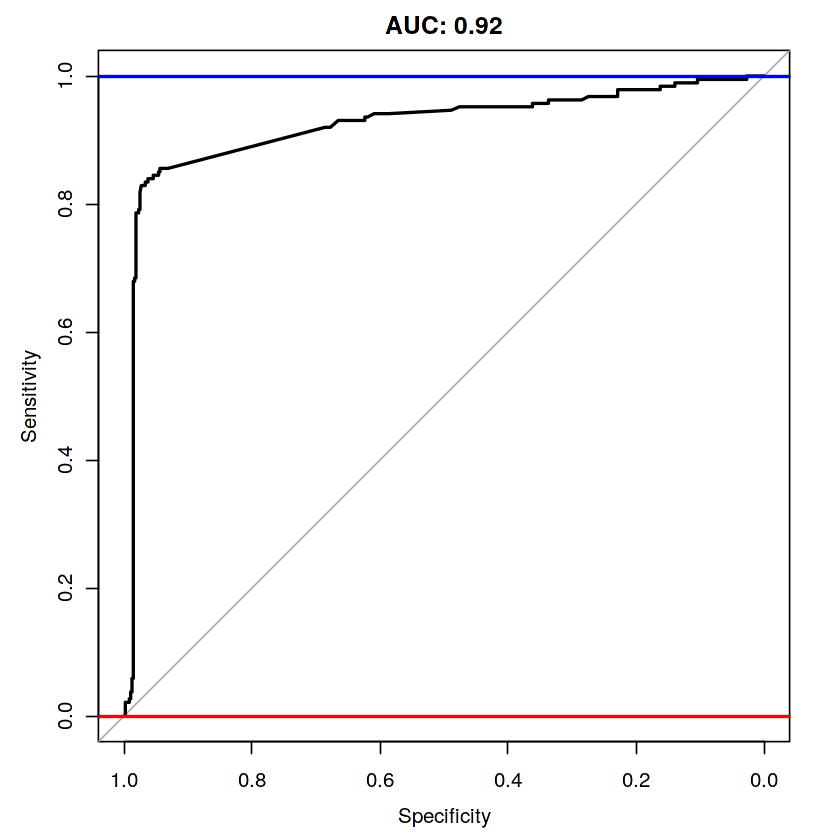

In [13]:
library(pROC)
test.current.prediction <-predict(gbm.model, newdata = test, n.trees = 500,
                                   type="response")

x.roc<-roc(response=test$SARS.Cov.2.exam.result, predictor=test.current.prediction)

plot(x.roc, ylim=c(0,1),
     main=paste('AUC:',round(x.roc$auc[[1]],2)))
abline(h=1,col='blue',lwd=2)
abline(h=0,col='red',lwd=2)

Below we can visualize how the choice of the threshold can influence the sensitivity and specificity of the model (in-sample analysis using train set). A model with high sensitivity achieves good results in finding positive patients among those true positive patients. However, the number of patients predicted to be positive can be too high and impact the model's specificity. Moreover, the hospital may not have enough resources to apply the necessary procedures for all patients assigned with a positive label if that number is too high. Hence, an ideal model is one that is well-balanced, i.e., one that has high sensitivity but it does not over-assign patients with positive labels.

Setting levels: control = 0, case = 1

Setting direction: controls < cases



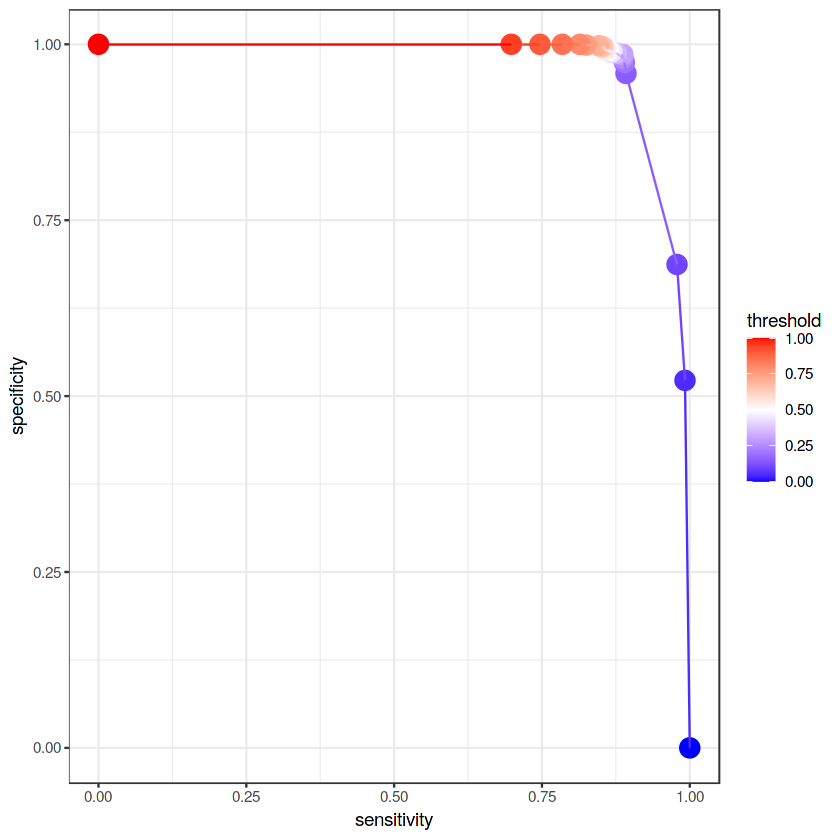

In [14]:
train.current.prediction <-predict(gbm.model, newdata = train, n.trees = 500,
                             type="response")
x.roc<-roc(response=train$SARS.Cov.2.exam.result, predictor=train.current.prediction)

cc <- coords(x.roc, seq(from = 0, to = 1, by = 0.05), ret=c("sensitivity", "specificity", "threshold"), transpose = FALSE)

library(ggplot2)
library(ggthemes)
mid<-median(cc$threshold)
ggplot(cc, aes(x=sensitivity, y=specificity,
               color=threshold, 
               fill=threshold)) + geom_point(size = 5) + geom_line() +
  theme_bw() +
  scale_color_gradient2(midpoint=mid, low="blue", mid="white", high="red", space ="Lab" ) +
  scale_fill_gradient2(midpoint=mid, low="blue", mid="white", high="red", space ="Lab" )

To determine which likelihood to choose and how to determine which patients to prioritize as more likely to be infected we discuss different scenarios which can be tied to distinct hospital-, city-, state- or country-specific policies. For each scenario, we will select the threshold from the train set that optimizes a given target objective function driven by the policy in the scenario in case.

#### Scenario 1: High availability of resources

In Scenario 1, we assume that the hospital has high availability of resources. In that way, the model can be relaxed and over-estimate the number of positive cases. Hence, our objective function is one that maximizes sensitivity. 

We use the train data to select the threshold that maximizes model's sensitivity. We then apply this threshold in the predicted probabilities in the test set. The procedure returns a probability threshold of 1.6% and the model presents a high sensitivity value of 95%, as intended. However, the high recall comes at the cost of specificity, which presents a low value of 34%. Moreover, about 74% of the patients from the test set were labeled as positive, hence the model has limited usage as a prioritization tool.

In [15]:
library(pROC)
train.current.prediction <-predict(gbm.model, newdata = train, n.trees = 500,
                             type="response")
                             

best.th<-coords(roc=x.roc, x=1, input="sensitivity", transpose = FALSE)$threshold
print(paste0("Optimal threshold = ", best.th))

oos.current.prediction <-predict(gbm.model, newdata = test, n.trees = 500,
                                   type="response")

sum(oos.current.prediction > best.th) / length(oos.current.prediction)
oos.x.roc<-roc(test$SARS.Cov.2.exam.result, predictor=oos.current.prediction)

auc(oos.x.roc)

BinModelPerformance(oos.current.prediction, best.th, test$SARS.Cov.2.exam.result)

[1] "Optimal threshold = 0.0164039401827982"


[1] 0.742515

Setting levels: control = 0, case = 1

Setting direction: controls < cases



Area under the curve: 0.923

          Reference
Prediction positive negative
  positive      179      317
  negative        8      164


ROC      Sens      Spec 
0.9229935 0.9572193 0.3409563

After making a prediction on the test set, we will then choose a threshold from the train set that maximizes the Youden J's statistic to achieve a well-balanced model. We observe that the model under Scenario 2 now delivers a Sensitivity of 84% compared to 95% from Scenario 1. However, it returns a Specificity of 96% while maintaining a high AUC of 92% (as the choice of threshold does not influence the AUC), hence delivering a more well-balanced model as expected. Moreover, now the model only assigns 26% of the test set with positive labels, showing to be useful as a potential patient prioritization tool.

[1] 0.742515

Setting levels: control = 0, case = 1

Setting direction: controls < cases



          Reference
Prediction positive negative
  positive      179      317
  negative        8      164


ROC      Sens      Spec 
0.9229935 0.9572193 0.3409563

Area under the curve: 0.923

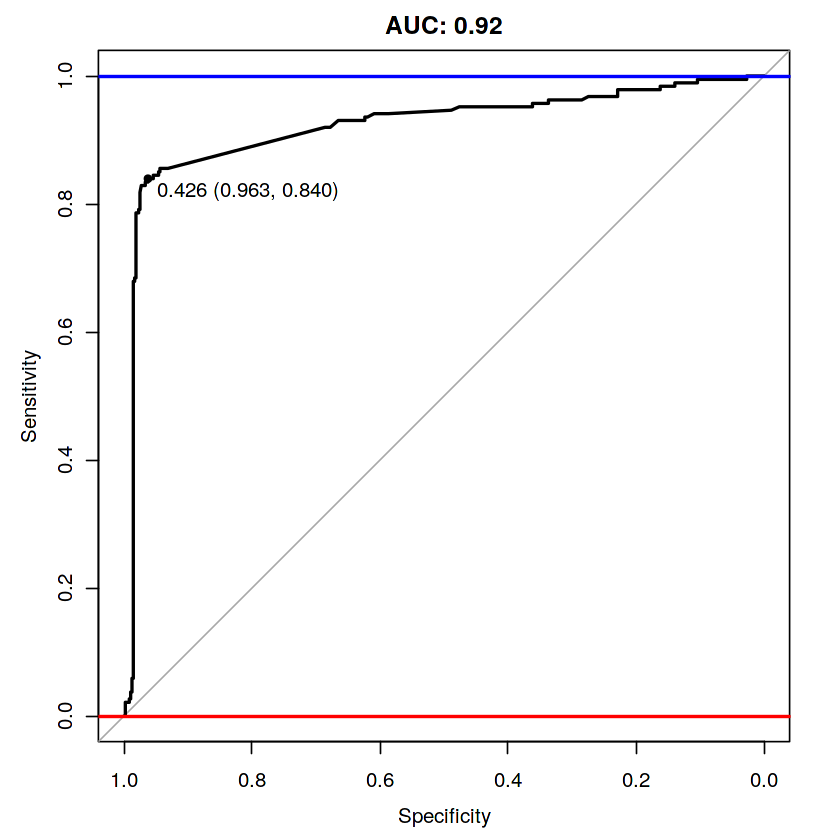

In [16]:
oos.current.prediction <-predict(gbm.model, newdata = test, n.trees = 500,
                                 type="response")

sum(oos.current.prediction > best.th) / length(oos.current.prediction)
oos.x.roc<-roc(test$SARS.Cov.2.exam.result, predictor=oos.current.prediction)

BinModelPerformance(oos.current.prediction, best.th,  test$SARS.Cov.2.exam.result)
auc(oos.x.roc)

# OUT-OF-SAMPLE ROC
plot(oos.x.roc, ylim=c(0,1), print.thres="best", print.thres.best.method="youden",
     main=paste('AUC:',round(oos.x.roc$auc[[1]],2)))
abline(h=1,col='blue',lwd=2)
abline(h=0,col='red',lwd=2)

#### Scenario 3: Limited resources, different policies

In Scenario 3, we incorporate the assumption that different hospitals might have different policies on what is an acceptable value for sensitivity or have different capacities to test prioritized pacients as well as have different prevalence levels. Hence, we generalize the models studied under Scenarios 1 and 2 by proposing a parameterized model with a cost function that allows doctors to over- or under-weight false negative classification as compared with a false positive classification depending on a target policy as well as input prevalence as input parameter.

Our objective function is

$max(sensitivity + r*specificy)$, 

where 

$r = 1 - prevalence / cost * prevalence$ 

and $r$ is the relative cost of a false negative classification (as compared with a false positive classification).Different countries and regions can have different prevalence, while different hospitals might have different policies to define the $cost$ parameter.

Our findings indicate that a practical model can be delivered with both specificity and sensitivity greater than 85% with the percentage number of patients ($num.positivie.pct$) labeled as positive lower than 30%, hence serving as a relevant prioritization tool. Moreover, the model is parametrized to allow for easy fine-tuning to adjust for target Sensitivity, prevalence or max number of patients to be prioritized.

In practice, health workers/hospitals using the proposed model would define a policy for a minimum acceptable Sensitivity level as well as target number of patients to be prioritized and current prevalence. These will serve as input parameters for the model to determine patients that would be prioritized as likely to test positive. The model would then output the likelihood of infection and accuracy, which can be used as a tool for prioritization and to support further medical decision making processes. On a periodic basis, input parameters/policy can be updated depending on health system conditions and the model would be re-trained also incorporation newly available data on an ongoing basis.

In [17]:
library(pROC)
library(gbm)
prevalence <-0.1

summ<-list()
num.positive.pct<-num.positive<-auc.summ<-vector()
cost.min<-1
cost.max<-200
# to do Vectorize :( 
for(cost in seq(from = cost.min, to = cost.max, by = 1)){

#obtain optimum threshold
best.th<-coords(x.roc, "best", ret="threshold", transpose = FALSE, 
                best.method="youden", best.weights=c(cost, prevalence))$threshold # default


oos.current.prediction <-predict(gbm.model, newdata = test, n.trees = 500,
                                 type="response")

#calculates pct/number of patients labeled as positive
num.positive.pct[cost]<-sum(oos.current.prediction > best.th) / length(oos.current.prediction)
num.positive[cost]<-sum(oos.current.prediction > best.th)

summ[[cost]]<-BinModelPerformance(oos.current.prediction, best.th, test$SARS.Cov.2.exam.result)

oos.x.roc<-roc(test$SARS.Cov.2.exam.result, predictor=oos.current.prediction)

auc.summ[cost]<-auc(oos.x.roc)

}

          Reference
Prediction positive negative
  positive      155       13
  negative       32      468


Setting levels: control = 0, case = 1

Setting direction: controls < cases



          Reference
Prediction positive negative
  positive      155       14
  negative       32      467


Setting levels: control = 0, case = 1

Setting direction: controls < cases



          Reference
Prediction positive negative
  positive      155       14
  negative       32      467


Setting levels: control = 0, case = 1

Setting direction: controls < cases



          Reference
Prediction positive negative
  positive      158       22
  negative       29      459


Setting levels: control = 0, case = 1

Setting direction: controls < cases



          Reference
Prediction positive negative
  positive      158       22
  negative       29      459


Setting levels: control = 0, case = 1

Setting direction: controls < cases



          Reference
Prediction positive negative
  positive      158       22
  negative       29      459


Setting levels: control = 0, case = 1

Setting direction: controls < cases



          Reference
Prediction positive negative
  positive      158       22
  negative       29      459


Setting levels: control = 0, case = 1

Setting direction: controls < cases



          Reference
Prediction positive negative
  positive      158       22
  negative       29      459


Setting levels: control = 0, case = 1

Setting direction: controls < cases



          Reference
Prediction positive negative
  positive      158       22
  negative       29      459


Setting levels: control = 0, case = 1

Setting direction: controls < cases



          Reference
Prediction positive negative
  positive      158       22
  negative       29      459


Setting levels: control = 0, case = 1

Setting direction: controls < cases



          Reference
Prediction positive negative
  positive      158       22
  negative       29      459


Setting levels: control = 0, case = 1

Setting direction: controls < cases



          Reference
Prediction positive negative
  positive      158       22
  negative       29      459


Setting levels: control = 0, case = 1

Setting direction: controls < cases



          Reference
Prediction positive negative
  positive      158       22
  negative       29      459


Setting levels: control = 0, case = 1

Setting direction: controls < cases



          Reference
Prediction positive negative
  positive      158       22
  negative       29      459


Setting levels: control = 0, case = 1

Setting direction: controls < cases



          Reference
Prediction positive negative
  positive      158       22
  negative       29      459


Setting levels: control = 0, case = 1

Setting direction: controls < cases



          Reference
Prediction positive negative
  positive      158       22
  negative       29      459


Setting levels: control = 0, case = 1

Setting direction: controls < cases



          Reference
Prediction positive negative
  positive      158       22
  negative       29      459


Setting levels: control = 0, case = 1

Setting direction: controls < cases



          Reference
Prediction positive negative
  positive      158       22
  negative       29      459


Setting levels: control = 0, case = 1

Setting direction: controls < cases



          Reference
Prediction positive negative
  positive      158       22
  negative       29      459


Setting levels: control = 0, case = 1

Setting direction: controls < cases



          Reference
Prediction positive negative
  positive      158       22
  negative       29      459


Setting levels: control = 0, case = 1

Setting direction: controls < cases



          Reference
Prediction positive negative
  positive      158       23
  negative       29      458


Setting levels: control = 0, case = 1

Setting direction: controls < cases



          Reference
Prediction positive negative
  positive      158       23
  negative       29      458


Setting levels: control = 0, case = 1

Setting direction: controls < cases



          Reference
Prediction positive negative
  positive      158       23
  negative       29      458


Setting levels: control = 0, case = 1

Setting direction: controls < cases



          Reference
Prediction positive negative
  positive      158       23
  negative       29      458


Setting levels: control = 0, case = 1

Setting direction: controls < cases



          Reference
Prediction positive negative
  positive      158       23
  negative       29      458


Setting levels: control = 0, case = 1

Setting direction: controls < cases



          Reference
Prediction positive negative
  positive      158       23
  negative       29      458


Setting levels: control = 0, case = 1

Setting direction: controls < cases



          Reference
Prediction positive negative
  positive      158       23
  negative       29      458


Setting levels: control = 0, case = 1

Setting direction: controls < cases



          Reference
Prediction positive negative
  positive      158       23
  negative       29      458


Setting levels: control = 0, case = 1

Setting direction: controls < cases



          Reference
Prediction positive negative
  positive      172      151
  negative       15      330


Setting levels: control = 0, case = 1

Setting direction: controls < cases



          Reference
Prediction positive negative
  positive      174      166
  negative       13      315


Setting levels: control = 0, case = 1

Setting direction: controls < cases



          Reference
Prediction positive negative
  positive      174      166
  negative       13      315


Setting levels: control = 0, case = 1

Setting direction: controls < cases



          Reference
Prediction positive negative
  positive      174      166
  negative       13      315


Setting levels: control = 0, case = 1

Setting direction: controls < cases



          Reference
Prediction positive negative
  positive      174      166
  negative       13      315


Setting levels: control = 0, case = 1

Setting direction: controls < cases



          Reference
Prediction positive negative
  positive      174      166
  negative       13      315


Setting levels: control = 0, case = 1

Setting direction: controls < cases



          Reference
Prediction positive negative
  positive      174      166
  negative       13      315


Setting levels: control = 0, case = 1

Setting direction: controls < cases



          Reference
Prediction positive negative
  positive      174      166
  negative       13      315


Setting levels: control = 0, case = 1

Setting direction: controls < cases



          Reference
Prediction positive negative
  positive      174      166
  negative       13      315


Setting levels: control = 0, case = 1

Setting direction: controls < cases



          Reference
Prediction positive negative
  positive      174      166
  negative       13      315


Setting levels: control = 0, case = 1

Setting direction: controls < cases



          Reference
Prediction positive negative
  positive      174      166
  negative       13      315


Setting levels: control = 0, case = 1

Setting direction: controls < cases



          Reference
Prediction positive negative
  positive      174      166
  negative       13      315


Setting levels: control = 0, case = 1

Setting direction: controls < cases



          Reference
Prediction positive negative
  positive      174      166
  negative       13      315


Setting levels: control = 0, case = 1

Setting direction: controls < cases



          Reference
Prediction positive negative
  positive      174      166
  negative       13      315


Setting levels: control = 0, case = 1

Setting direction: controls < cases



          Reference
Prediction positive negative
  positive      174      166
  negative       13      315


Setting levels: control = 0, case = 1

Setting direction: controls < cases



          Reference
Prediction positive negative
  positive      174      166
  negative       13      315


Setting levels: control = 0, case = 1

Setting direction: controls < cases



          Reference
Prediction positive negative
  positive      174      166
  negative       13      315


Setting levels: control = 0, case = 1

Setting direction: controls < cases



          Reference
Prediction positive negative
  positive      174      166
  negative       13      315


Setting levels: control = 0, case = 1

Setting direction: controls < cases



          Reference
Prediction positive negative
  positive      174      166
  negative       13      315


Setting levels: control = 0, case = 1

Setting direction: controls < cases



          Reference
Prediction positive negative
  positive      174      166
  negative       13      315


Setting levels: control = 0, case = 1

Setting direction: controls < cases



          Reference
Prediction positive negative
  positive      174      166
  negative       13      315


Setting levels: control = 0, case = 1

Setting direction: controls < cases



          Reference
Prediction positive negative
  positive      174      166
  negative       13      315


Setting levels: control = 0, case = 1

Setting direction: controls < cases



          Reference
Prediction positive negative
  positive      174      166
  negative       13      315


Setting levels: control = 0, case = 1

Setting direction: controls < cases



          Reference
Prediction positive negative
  positive      174      166
  negative       13      315


Setting levels: control = 0, case = 1

Setting direction: controls < cases



          Reference
Prediction positive negative
  positive      174      166
  negative       13      315


Setting levels: control = 0, case = 1

Setting direction: controls < cases



          Reference
Prediction positive negative
  positive      174      166
  negative       13      315


Setting levels: control = 0, case = 1

Setting direction: controls < cases



          Reference
Prediction positive negative
  positive      174      166
  negative       13      315


Setting levels: control = 0, case = 1

Setting direction: controls < cases



          Reference
Prediction positive negative
  positive      174      166
  negative       13      315


Setting levels: control = 0, case = 1

Setting direction: controls < cases



          Reference
Prediction positive negative
  positive      174      166
  negative       13      315


Setting levels: control = 0, case = 1

Setting direction: controls < cases



          Reference
Prediction positive negative
  positive      174      166
  negative       13      315


Setting levels: control = 0, case = 1

Setting direction: controls < cases



          Reference
Prediction positive negative
  positive      174      166
  negative       13      315


Setting levels: control = 0, case = 1

Setting direction: controls < cases



          Reference
Prediction positive negative
  positive      174      166
  negative       13      315


Setting levels: control = 0, case = 1

Setting direction: controls < cases



          Reference
Prediction positive negative
  positive      174      166
  negative       13      315


Setting levels: control = 0, case = 1

Setting direction: controls < cases



          Reference
Prediction positive negative
  positive      174      166
  negative       13      315


Setting levels: control = 0, case = 1

Setting direction: controls < cases



          Reference
Prediction positive negative
  positive      174      166
  negative       13      315


Setting levels: control = 0, case = 1

Setting direction: controls < cases



          Reference
Prediction positive negative
  positive      174      166
  negative       13      315


Setting levels: control = 0, case = 1

Setting direction: controls < cases



          Reference
Prediction positive negative
  positive      174      166
  negative       13      315


Setting levels: control = 0, case = 1

Setting direction: controls < cases



          Reference
Prediction positive negative
  positive      174      166
  negative       13      315


Setting levels: control = 0, case = 1

Setting direction: controls < cases



          Reference
Prediction positive negative
  positive      174      166
  negative       13      315


Setting levels: control = 0, case = 1

Setting direction: controls < cases



          Reference
Prediction positive negative
  positive      174      166
  negative       13      315


Setting levels: control = 0, case = 1

Setting direction: controls < cases



          Reference
Prediction positive negative
  positive      174      166
  negative       13      315


Setting levels: control = 0, case = 1

Setting direction: controls < cases



          Reference
Prediction positive negative
  positive      174      166
  negative       13      315


Setting levels: control = 0, case = 1

Setting direction: controls < cases



          Reference
Prediction positive negative
  positive      174      166
  negative       13      315


Setting levels: control = 0, case = 1

Setting direction: controls < cases



          Reference
Prediction positive negative
  positive      174      166
  negative       13      315


Setting levels: control = 0, case = 1

Setting direction: controls < cases



          Reference
Prediction positive negative
  positive      174      166
  negative       13      315


Setting levels: control = 0, case = 1

Setting direction: controls < cases



          Reference
Prediction positive negative
  positive      174      166
  negative       13      315


Setting levels: control = 0, case = 1

Setting direction: controls < cases



          Reference
Prediction positive negative
  positive      174      166
  negative       13      315


Setting levels: control = 0, case = 1

Setting direction: controls < cases



          Reference
Prediction positive negative
  positive      174      166
  negative       13      315


Setting levels: control = 0, case = 1

Setting direction: controls < cases



          Reference
Prediction positive negative
  positive      174      166
  negative       13      315


Setting levels: control = 0, case = 1

Setting direction: controls < cases



          Reference
Prediction positive negative
  positive      174      166
  negative       13      315


Setting levels: control = 0, case = 1

Setting direction: controls < cases



          Reference
Prediction positive negative
  positive      174      166
  negative       13      315


Setting levels: control = 0, case = 1

Setting direction: controls < cases



          Reference
Prediction positive negative
  positive      174      166
  negative       13      315


Setting levels: control = 0, case = 1

Setting direction: controls < cases



          Reference
Prediction positive negative
  positive      174      166
  negative       13      315


Setting levels: control = 0, case = 1

Setting direction: controls < cases



          Reference
Prediction positive negative
  positive      174      166
  negative       13      315


Setting levels: control = 0, case = 1

Setting direction: controls < cases



          Reference
Prediction positive negative
  positive      174      166
  negative       13      315


Setting levels: control = 0, case = 1

Setting direction: controls < cases



          Reference
Prediction positive negative
  positive      174      166
  negative       13      315


Setting levels: control = 0, case = 1

Setting direction: controls < cases



          Reference
Prediction positive negative
  positive      174      166
  negative       13      315


Setting levels: control = 0, case = 1

Setting direction: controls < cases



          Reference
Prediction positive negative
  positive      174      166
  negative       13      315


Setting levels: control = 0, case = 1

Setting direction: controls < cases



          Reference
Prediction positive negative
  positive      174      166
  negative       13      315


Setting levels: control = 0, case = 1

Setting direction: controls < cases



          Reference
Prediction positive negative
  positive      174      166
  negative       13      315


Setting levels: control = 0, case = 1

Setting direction: controls < cases



          Reference
Prediction positive negative
  positive      174      166
  negative       13      315


Setting levels: control = 0, case = 1

Setting direction: controls < cases



          Reference
Prediction positive negative
  positive      174      166
  negative       13      315


Setting levels: control = 0, case = 1

Setting direction: controls < cases



          Reference
Prediction positive negative
  positive      174      166
  negative       13      315


Setting levels: control = 0, case = 1

Setting direction: controls < cases



          Reference
Prediction positive negative
  positive      174      166
  negative       13      315


Setting levels: control = 0, case = 1

Setting direction: controls < cases



          Reference
Prediction positive negative
  positive      174      166
  negative       13      315


Setting levels: control = 0, case = 1

Setting direction: controls < cases



          Reference
Prediction positive negative
  positive      174      166
  negative       13      315


Setting levels: control = 0, case = 1

Setting direction: controls < cases



          Reference
Prediction positive negative
  positive      174      166
  negative       13      315


Setting levels: control = 0, case = 1

Setting direction: controls < cases



          Reference
Prediction positive negative
  positive      174      166
  negative       13      315


Setting levels: control = 0, case = 1

Setting direction: controls < cases



          Reference
Prediction positive negative
  positive      174      166
  negative       13      315


Setting levels: control = 0, case = 1

Setting direction: controls < cases



          Reference
Prediction positive negative
  positive      174      166
  negative       13      315


Setting levels: control = 0, case = 1

Setting direction: controls < cases



          Reference
Prediction positive negative
  positive      174      166
  negative       13      315


Setting levels: control = 0, case = 1

Setting direction: controls < cases



          Reference
Prediction positive negative
  positive      174      166
  negative       13      315


Setting levels: control = 0, case = 1

Setting direction: controls < cases



          Reference
Prediction positive negative
  positive      174      166
  negative       13      315


Setting levels: control = 0, case = 1

Setting direction: controls < cases



          Reference
Prediction positive negative
  positive      174      166
  negative       13      315


Setting levels: control = 0, case = 1

Setting direction: controls < cases



          Reference
Prediction positive negative
  positive      174      166
  negative       13      315


Setting levels: control = 0, case = 1

Setting direction: controls < cases



          Reference
Prediction positive negative
  positive      174      166
  negative       13      315


Setting levels: control = 0, case = 1

Setting direction: controls < cases



          Reference
Prediction positive negative
  positive      174      166
  negative       13      315


Setting levels: control = 0, case = 1

Setting direction: controls < cases



          Reference
Prediction positive negative
  positive      174      166
  negative       13      315


Setting levels: control = 0, case = 1

Setting direction: controls < cases



          Reference
Prediction positive negative
  positive      174      166
  negative       13      315


Setting levels: control = 0, case = 1

Setting direction: controls < cases



          Reference
Prediction positive negative
  positive      174      166
  negative       13      315


Setting levels: control = 0, case = 1

Setting direction: controls < cases



          Reference
Prediction positive negative
  positive      174      166
  negative       13      315


Setting levels: control = 0, case = 1

Setting direction: controls < cases



          Reference
Prediction positive negative
  positive      174      166
  negative       13      315


Setting levels: control = 0, case = 1

Setting direction: controls < cases



          Reference
Prediction positive negative
  positive      174      166
  negative       13      315


Setting levels: control = 0, case = 1

Setting direction: controls < cases



          Reference
Prediction positive negative
  positive      174      166
  negative       13      315


Setting levels: control = 0, case = 1

Setting direction: controls < cases



          Reference
Prediction positive negative
  positive      174      166
  negative       13      315


Setting levels: control = 0, case = 1

Setting direction: controls < cases



          Reference
Prediction positive negative
  positive      174      166
  negative       13      315


Setting levels: control = 0, case = 1

Setting direction: controls < cases



          Reference
Prediction positive negative
  positive      177      246
  negative       10      235


Setting levels: control = 0, case = 1

Setting direction: controls < cases



          Reference
Prediction positive negative
  positive      177      246
  negative       10      235


Setting levels: control = 0, case = 1

Setting direction: controls < cases



          Reference
Prediction positive negative
  positive      177      246
  negative       10      235


Setting levels: control = 0, case = 1

Setting direction: controls < cases



          Reference
Prediction positive negative
  positive      177      246
  negative       10      235


Setting levels: control = 0, case = 1

Setting direction: controls < cases



          Reference
Prediction positive negative
  positive      177      246
  negative       10      235


Setting levels: control = 0, case = 1

Setting direction: controls < cases



          Reference
Prediction positive negative
  positive      177      246
  negative       10      235


Setting levels: control = 0, case = 1

Setting direction: controls < cases



          Reference
Prediction positive negative
  positive      177      246
  negative       10      235


Setting levels: control = 0, case = 1

Setting direction: controls < cases



          Reference
Prediction positive negative
  positive      177      246
  negative       10      235


Setting levels: control = 0, case = 1

Setting direction: controls < cases



          Reference
Prediction positive negative
  positive      177      246
  negative       10      235


Setting levels: control = 0, case = 1

Setting direction: controls < cases



          Reference
Prediction positive negative
  positive      177      246
  negative       10      235


Setting levels: control = 0, case = 1

Setting direction: controls < cases



          Reference
Prediction positive negative
  positive      177      246
  negative       10      235


Setting levels: control = 0, case = 1

Setting direction: controls < cases



          Reference
Prediction positive negative
  positive      177      246
  negative       10      235


Setting levels: control = 0, case = 1

Setting direction: controls < cases



          Reference
Prediction positive negative
  positive      177      246
  negative       10      235


Setting levels: control = 0, case = 1

Setting direction: controls < cases



          Reference
Prediction positive negative
  positive      177      246
  negative       10      235


Setting levels: control = 0, case = 1

Setting direction: controls < cases



          Reference
Prediction positive negative
  positive      177      246
  negative       10      235


Setting levels: control = 0, case = 1

Setting direction: controls < cases



          Reference
Prediction positive negative
  positive      177      246
  negative       10      235


Setting levels: control = 0, case = 1

Setting direction: controls < cases



          Reference
Prediction positive negative
  positive      177      246
  negative       10      235


Setting levels: control = 0, case = 1

Setting direction: controls < cases



          Reference
Prediction positive negative
  positive      177      246
  negative       10      235


Setting levels: control = 0, case = 1

Setting direction: controls < cases



          Reference
Prediction positive negative
  positive      177      246
  negative       10      235


Setting levels: control = 0, case = 1

Setting direction: controls < cases



          Reference
Prediction positive negative
  positive      177      246
  negative       10      235


Setting levels: control = 0, case = 1

Setting direction: controls < cases



          Reference
Prediction positive negative
  positive      177      246
  negative       10      235


Setting levels: control = 0, case = 1

Setting direction: controls < cases



          Reference
Prediction positive negative
  positive      177      246
  negative       10      235


Setting levels: control = 0, case = 1

Setting direction: controls < cases



          Reference
Prediction positive negative
  positive      177      246
  negative       10      235


Setting levels: control = 0, case = 1

Setting direction: controls < cases



          Reference
Prediction positive negative
  positive      177      246
  negative       10      235


Setting levels: control = 0, case = 1

Setting direction: controls < cases



          Reference
Prediction positive negative
  positive      177      246
  negative       10      235


Setting levels: control = 0, case = 1

Setting direction: controls < cases



          Reference
Prediction positive negative
  positive      177      246
  negative       10      235


Setting levels: control = 0, case = 1

Setting direction: controls < cases



          Reference
Prediction positive negative
  positive      177      246
  negative       10      235


Setting levels: control = 0, case = 1

Setting direction: controls < cases



          Reference
Prediction positive negative
  positive      177      246
  negative       10      235


Setting levels: control = 0, case = 1

Setting direction: controls < cases



          Reference
Prediction positive negative
  positive      177      246
  negative       10      235


Setting levels: control = 0, case = 1

Setting direction: controls < cases



          Reference
Prediction positive negative
  positive      177      246
  negative       10      235


Setting levels: control = 0, case = 1

Setting direction: controls < cases



          Reference
Prediction positive negative
  positive      177      246
  negative       10      235


Setting levels: control = 0, case = 1

Setting direction: controls < cases



          Reference
Prediction positive negative
  positive      177      246
  negative       10      235


Setting levels: control = 0, case = 1

Setting direction: controls < cases



          Reference
Prediction positive negative
  positive      177      246
  negative       10      235


Setting levels: control = 0, case = 1

Setting direction: controls < cases



          Reference
Prediction positive negative
  positive      177      246
  negative       10      235


Setting levels: control = 0, case = 1

Setting direction: controls < cases



          Reference
Prediction positive negative
  positive      177      246
  negative       10      235


Setting levels: control = 0, case = 1

Setting direction: controls < cases



          Reference
Prediction positive negative
  positive      177      246
  negative       10      235


Setting levels: control = 0, case = 1

Setting direction: controls < cases



          Reference
Prediction positive negative
  positive      177      246
  negative       10      235


Setting levels: control = 0, case = 1

Setting direction: controls < cases



          Reference
Prediction positive negative
  positive      177      246
  negative       10      235


Setting levels: control = 0, case = 1

Setting direction: controls < cases



          Reference
Prediction positive negative
  positive      177      246
  negative       10      235


Setting levels: control = 0, case = 1

Setting direction: controls < cases



          Reference
Prediction positive negative
  positive      177      246
  negative       10      235


Setting levels: control = 0, case = 1

Setting direction: controls < cases



          Reference
Prediction positive negative
  positive      177      246
  negative       10      235


Setting levels: control = 0, case = 1

Setting direction: controls < cases



          Reference
Prediction positive negative
  positive      177      246
  negative       10      235


Setting levels: control = 0, case = 1

Setting direction: controls < cases



          Reference
Prediction positive negative
  positive      177      246
  negative       10      235


Setting levels: control = 0, case = 1

Setting direction: controls < cases



          Reference
Prediction positive negative
  positive      177      246
  negative       10      235


Setting levels: control = 0, case = 1

Setting direction: controls < cases



          Reference
Prediction positive negative
  positive      177      246
  negative       10      235


Setting levels: control = 0, case = 1

Setting direction: controls < cases



          Reference
Prediction positive negative
  positive      177      246
  negative       10      235


Setting levels: control = 0, case = 1

Setting direction: controls < cases



          Reference
Prediction positive negative
  positive      177      246
  negative       10      235


Setting levels: control = 0, case = 1

Setting direction: controls < cases



          Reference
Prediction positive negative
  positive      177      246
  negative       10      235


Setting levels: control = 0, case = 1

Setting direction: controls < cases



          Reference
Prediction positive negative
  positive      177      246
  negative       10      235


Setting levels: control = 0, case = 1

Setting direction: controls < cases



          Reference
Prediction positive negative
  positive      177      246
  negative       10      235


Setting levels: control = 0, case = 1

Setting direction: controls < cases



          Reference
Prediction positive negative
  positive      177      246
  negative       10      235


Setting levels: control = 0, case = 1

Setting direction: controls < cases



          Reference
Prediction positive negative
  positive      177      246
  negative       10      235


Setting levels: control = 0, case = 1

Setting direction: controls < cases



          Reference
Prediction positive negative
  positive      177      246
  negative       10      235


Setting levels: control = 0, case = 1

Setting direction: controls < cases



          Reference
Prediction positive negative
  positive      177      246
  negative       10      235


Setting levels: control = 0, case = 1

Setting direction: controls < cases



          Reference
Prediction positive negative
  positive      177      246
  negative       10      235


Setting levels: control = 0, case = 1

Setting direction: controls < cases



          Reference
Prediction positive negative
  positive      177      246
  negative       10      235


Setting levels: control = 0, case = 1

Setting direction: controls < cases



          Reference
Prediction positive negative
  positive      177      246
  negative       10      235


Setting levels: control = 0, case = 1

Setting direction: controls < cases



          Reference
Prediction positive negative
  positive      177      246
  negative       10      235


Setting levels: control = 0, case = 1

Setting direction: controls < cases



          Reference
Prediction positive negative
  positive      177      246
  negative       10      235


Setting levels: control = 0, case = 1

Setting direction: controls < cases



          Reference
Prediction positive negative
  positive      177      246
  negative       10      235


Setting levels: control = 0, case = 1

Setting direction: controls < cases



          Reference
Prediction positive negative
  positive      177      246
  negative       10      235


Setting levels: control = 0, case = 1

Setting direction: controls < cases



          Reference
Prediction positive negative
  positive      177      246
  negative       10      235


Setting levels: control = 0, case = 1

Setting direction: controls < cases



          Reference
Prediction positive negative
  positive      177      246
  negative       10      235


Setting levels: control = 0, case = 1

Setting direction: controls < cases



          Reference
Prediction positive negative
  positive      177      246
  negative       10      235


Setting levels: control = 0, case = 1

Setting direction: controls < cases



          Reference
Prediction positive negative
  positive      177      246
  negative       10      235


Setting levels: control = 0, case = 1

Setting direction: controls < cases



          Reference
Prediction positive negative
  positive      177      246
  negative       10      235


Setting levels: control = 0, case = 1

Setting direction: controls < cases



          Reference
Prediction positive negative
  positive      177      246
  negative       10      235


Setting levels: control = 0, case = 1

Setting direction: controls < cases



          Reference
Prediction positive negative
  positive      177      246
  negative       10      235


Setting levels: control = 0, case = 1

Setting direction: controls < cases



          Reference
Prediction positive negative
  positive      179      317
  negative        8      164


Setting levels: control = 0, case = 1

Setting direction: controls < cases



          Reference
Prediction positive negative
  positive      179      317
  negative        8      164


Setting levels: control = 0, case = 1

Setting direction: controls < cases



          Reference
Prediction positive negative
  positive      179      317
  negative        8      164


Setting levels: control = 0, case = 1

Setting direction: controls < cases



          Reference
Prediction positive negative
  positive      179      317
  negative        8      164


Setting levels: control = 0, case = 1

Setting direction: controls < cases



          Reference
Prediction positive negative
  positive      179      317
  negative        8      164


Setting levels: control = 0, case = 1

Setting direction: controls < cases



          Reference
Prediction positive negative
  positive      179      317
  negative        8      164


Setting levels: control = 0, case = 1

Setting direction: controls < cases



          Reference
Prediction positive negative
  positive      179      317
  negative        8      164


Setting levels: control = 0, case = 1

Setting direction: controls < cases



          Reference
Prediction positive negative
  positive      179      317
  negative        8      164


Setting levels: control = 0, case = 1

Setting direction: controls < cases



          Reference
Prediction positive negative
  positive      179      317
  negative        8      164


Setting levels: control = 0, case = 1

Setting direction: controls < cases



          Reference
Prediction positive negative
  positive      179      317
  negative        8      164


Setting levels: control = 0, case = 1

Setting direction: controls < cases



          Reference
Prediction positive negative
  positive      179      317
  negative        8      164


Setting levels: control = 0, case = 1

Setting direction: controls < cases



          Reference
Prediction positive negative
  positive      179      317
  negative        8      164


Setting levels: control = 0, case = 1

Setting direction: controls < cases



          Reference
Prediction positive negative
  positive      179      317
  negative        8      164


Setting levels: control = 0, case = 1

Setting direction: controls < cases



          Reference
Prediction positive negative
  positive      179      317
  negative        8      164


Setting levels: control = 0, case = 1

Setting direction: controls < cases



          Reference
Prediction positive negative
  positive      179      317
  negative        8      164


Setting levels: control = 0, case = 1

Setting direction: controls < cases



          Reference
Prediction positive negative
  positive      179      317
  negative        8      164


Setting levels: control = 0, case = 1

Setting direction: controls < cases



          Reference
Prediction positive negative
  positive      179      317
  negative        8      164


Setting levels: control = 0, case = 1

Setting direction: controls < cases



          Reference
Prediction positive negative
  positive      179      317
  negative        8      164


Setting levels: control = 0, case = 1

Setting direction: controls < cases



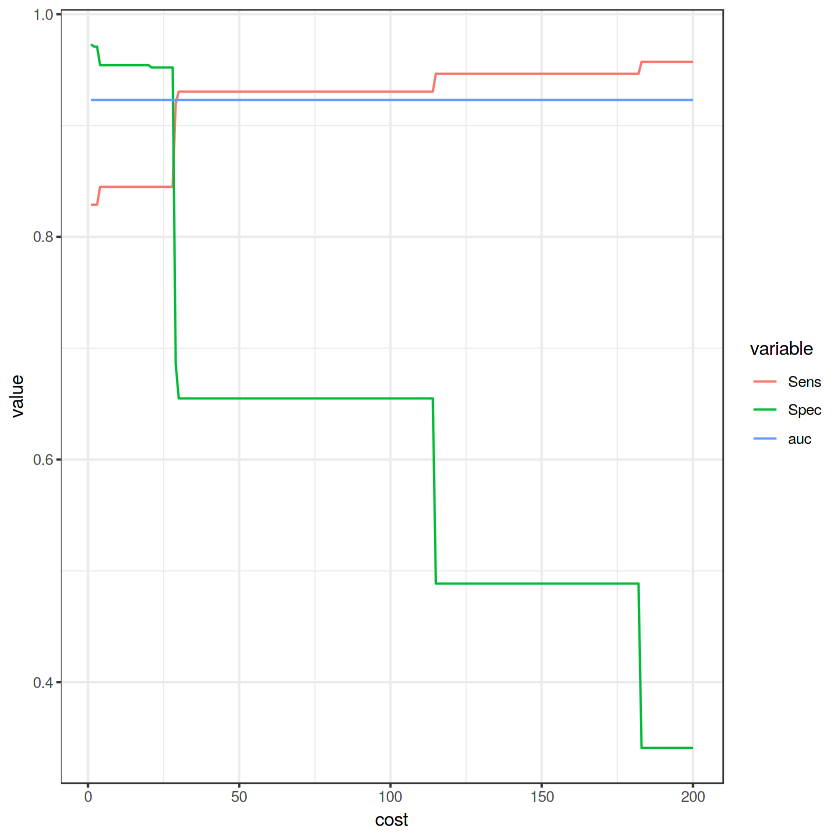

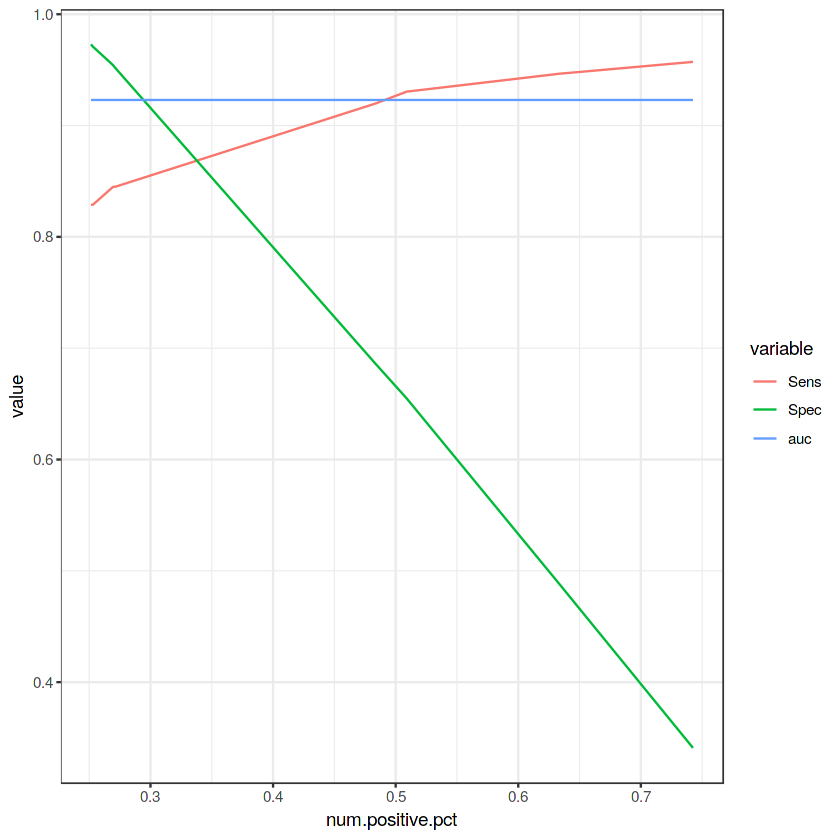

In [18]:
df.summ <- data.frame(matrix(unlist(summ), nrow=length(summ), byrow=T))
df.summ$num.positive <- num.positive
df.summ$num.positive.pct <- num.positive.pct
df.summ$auc <- auc.summ
df.summ$cost <- cost.min:cost.max
names(df.summ)<-c(names(summ[[1]]), "num.positive",  "num.positive.pct", "auc","cost")

df.summ$ROC<-NULL

library(reshape)
mdata <- melt(df.summ, id=c("cost","num.positive", "num.positive.pct"))

library(ggplot2)
ggplot(mdata, aes(x = cost, y = value)) + 
  geom_line(aes(color = variable)) + 
  theme_bw()

ggplot(mdata, aes(x = num.positive.pct, y = value)) + 
  geom_line(aes(color = variable)) + 
  theme_bw()


## Conclusion

In this work, we showed that it is possible to predict the test result for SARS-CoV-2 based on the results of laboratory tests commonly collected for a suspected COVID-19 case by analyzing a sample of 5644 patients of which 558 tested positive for SARS-CoV-2 from the Hospital Israelita Albert Einstein. 

The proposed model is of practical application with 92% AUC and Sensitivity/Specificity levels greater than 85% depending on target policies/scenarios. The model has high interpretability further showing that patients admitted with COVID-19 symptoms who tested negative for Rhinovirus Enterovirus, Influenza B and Inf.A.H1N1.2009 and presented low levels of Leukocytes and Platelets were more likely to test positive for SARS-CoV-2. 

We have also studied how model’s performance can be adapted according to different scenarios which are defined as a function of target Sensitivity or hospital’s policy to prioritize a number of patients. We showed that Specificity levels above 98% can be achieved if the hospital were willing to consider a test that selects as many as 75% of the patients as likely to test positive. However, we showed that a well-balanced model can be achieved (both Specificity and Sensitivity greater than 85%) with a patient prioritization level of about 25%, hence proving to be a relevant prioritization procedure. Model’s performance balance can be defined as a function of hospital-specific policies that consider prevalence, patients prioritization level or target Sensitivity levels.

We employed a parsimonious modeling approach and the construction of a simple yet effective and transparent baseline model. We acknowledge that findings should be taken with caution because of several limitations in the study, including: (i) small number of data samples; (ii) imbalanced dataset; (iii) high sparsity in the predictors. Also, we have as potential bias the presence of a viral screening in the common lab tests of the particular hospital studied in this study, which might not be available in many other medical facilities in Brazil or worldwide. 

Further research can address a small quantity of variables but with vitals and physical examination records. Given the profile of the disease, image study from x-ray and tomography could provide early detection of severe cases, predicting the need of an ICU bed.